# Toward patch-free:
## Training

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
#import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/BigPatch/"  
PATCH_SIZE=224  # 224 matches VGG
PATCH_SIZE=256
PATCH_SIZE=512    # dies at batch size 32
# PATCH_SIZE=1024   # dies
# PATCH_SIZE=2048   # kernel death at start of training
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "PatchFree_003" 
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)
BATCH_SIZE = 32
BATCH_SIZE = 16
IMG_SIZE = (PATCH_SIZE,PATCH_SIZE)

Will overwrite model at /home/jrm/Martinez/models/PatchFree_003


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 12903 files belonging to 2 classes.
Found 3225 files belonging to 2 classes.


In [4]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
#iterator = valid_dataset.take(5)
#for x in iterator:
#    print(x[0].shape)
#    print(x[1])

In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 2
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    #kl.RandomFlip(),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(16,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])


In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=5
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/5
807/807 [==============================] - 222s 271ms/step - loss: 0.5595 - accuracy: 0.7721 - val_loss: 0.5196 - val_accuracy: 0.7857
Epoch 2/5
807/807 [==============================] - 216s 267ms/step - loss: 0.5298 - accuracy: 0.7856 - val_loss: 0.5200 - val_accuracy: 0.7857
Epoch 3/5
807/807 [==============================] - 213s 263ms/step - loss: 0.5255 - accuracy: 0.7857 - val_loss: 0.5207 - val_accuracy: 0.7857
Epoch 4/5
807/807 [==============================] - 212s 263ms/step - loss: 0.5227 - accuracy: 0.7857 - val_loss: 0.5194 - val_accuracy: 0.7857
Epoch 5/5
807/807 [==============================] - 212s 263ms/step - loss: 0.5201 - accuracy: 0.7857 - val_loss: 0.5203 - val_accuracy: 0.7857
Elapsed time: 1075.0677382946014


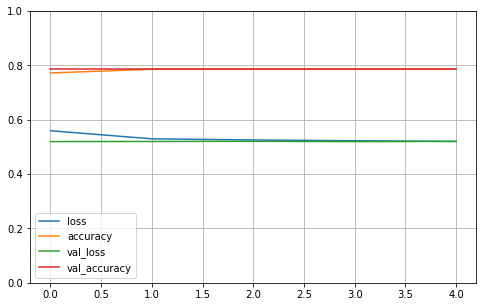

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
# cnn.save(filepath)